In [96]:
import torch
import numpy as np
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score

In [97]:
transform = transforms.Compose([transforms.ToTensor()])
train_path = 'Data/double_mnist_seed_123_image_size_64_64/train/'
val_path = 'Data/double_mnist_seed_123_image_size_64_64/val/'
test_path = 'Data/double_mnist_seed_123_image_size_64_64/test/'
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)
same_digits = ['00','11','22','33','44','55','66','77','88','99']

In [98]:
classes = train_dataset.classes
updated_train_dataset = []
for img,label in train_dataset:
    if(classes[label] not in same_digits):
        num = int(classes[label])
        updated_train_dataset.append((img,torch.tensor([num//10,num % 10])))

In [99]:
classes = test_dataset.classes
updated_test_dataset = []
for img,label in test_dataset:
    if(classes[label] not in same_digits):
        num = int(classes[label])
        updated_test_dataset.append((img,torch.tensor([num//10,num % 10])))

In [100]:
classes = val_dataset.classes
updated_val_dataset = []
for img,label in val_dataset:
    if(classes[label] not in same_digits):
        num = int(classes[label])
        updated_val_dataset.append((img,torch.tensor([num//10,num % 10])))

In [28]:
# classes = test_dataset.classes
# updated_test_dataset = []
# for img,label in test_dataset:
#     if(classes[label] not in same_digits):
#         num = int(classes[label])
#         updated_test_dataset.append((img,torch.tensor([num//10,label % 10])))

In [101]:
from torch.utils.data import DataLoader
train_loader = DataLoader(updated_train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(updated_test_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(updated_val_dataset, batch_size = 64, shuffle = True)

# 5.1.1

In [109]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers , hidden_sizes, output_size):
        super(MLP, self).__init__()
        hidden_sizes = [input_size]+hidden_sizes
        self.hidden_layers = hidden_layers
        self.layers = nn.ModuleList([nn.Linear(hidden_sizes[idx-1], hidden_sizes[idx]) for idx in range(1,hidden_layers+1)])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[-1], output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x[:,0,:,:].view(x.size(0), -1)  # Flatten the input
        for layer in range(self.hidden_layers):
            x = self.layers[layer](x)
            x = self.relu(x)
    
        x = self.fc2(x)
        digit1 = x[:,:10]
        digit2 = x[:,10:]
        return digit1,digit2

In [110]:
input_size = 64*64*1
hidden_layers = 1
hidden_sizes = [300]
num_classes = 20 

model = MLP(input_size, hidden_layers, hidden_sizes, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [111]:
training_losses = []
validation_losses = []
best_validation = float('inf')
for epoch in range(10):
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(inputs)
            loss1 = criterion(output1, labels[:,0])
            loss2 = criterion(output2, labels[:,1])
            total = loss1 + loss2
            loss_train += total.item()
#             loss1.backward()
#             loss2.backward()
            total.backward()
            optimizer.step()
        
        print(f"Epoch {epoch + 1}, Training Loss: {loss_train / len(train_loader)}")
        training_losses.append(loss_train / len(train_loader))
        
        model.eval()
        loss_eval = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                output1, output2 = model(inputs)
                loss1 = criterion(output1, labels[:,0])
                loss2 = criterion(output2, labels[:,1])
                total = loss1 + loss2
                loss_eval += total
        print(f"Epoch {epoch + 1}, validation Loss: {loss_eval / len(val_loader)}")
        validation_losses.append(loss_eval / len(val_loader))
        if(validation_losses[-1] < best_validation):
            torch.save(model.state_dict(), 'Model/mlp.pth')

if(validation_losses[-1] < best_validation):
    torch.save(model.state_dict(), 'Model/mlp.pth')

Epoch 1, Training Loss: 2.5330052035383246
Epoch 1, validation Loss: 2.2483158111572266
Epoch 2, Training Loss: 1.0535978156387347
Epoch 2, validation Loss: 1.8673821687698364
Epoch 3, Training Loss: 0.6660839890960559
Epoch 3, validation Loss: 1.8294150829315186
Epoch 4, Training Loss: 0.4704396797481682
Epoch 4, validation Loss: 1.8984211683273315
Epoch 5, Training Loss: 0.34298301648344465
Epoch 5, validation Loss: 1.891428828239441
Epoch 6, Training Loss: 0.2539978012475447
Epoch 6, validation Loss: 1.9708229303359985
Epoch 7, Training Loss: 0.18666703398560217
Epoch 7, validation Loss: 2.0438342094421387
Epoch 8, Training Loss: 0.13345468172838432
Epoch 8, validation Loss: 2.1021974086761475
Epoch 9, Training Loss: 0.10600217924450238
Epoch 9, validation Loss: 2.3022875785827637
Epoch 10, Training Loss: 0.08535232289993053
Epoch 10, validation Loss: 2.549259662628174


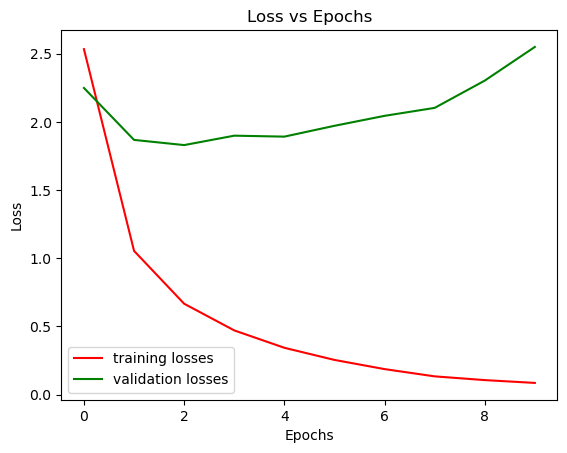

In [112]:
plt.plot(range(10), training_losses, color='red')
plt.plot(range(10), validation_losses, color='green')
plt.legend(['training losses','validation losses'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [113]:
model = MLP(input_size, hidden_layers, hidden_sizes, num_classes)
model.load_state_dict(torch.load('Model/mlp.pth'))
with torch.no_grad():
    accuracy_train = 0
    for inputs, labels in train_loader:
        output1, output2 = model(inputs)
        predicted_1 = torch.argmax(output1, dim = 1,keepdims = True)
        predicted_2 = torch.argmax(output2, dim = 1, keepdims = True)
        predicted_labels = torch.cat((predicted_1, predicted_2), dim = 1)
        accuracy = 0
        for idx in range(len(predicted_labels)):
            if(labels[idx][0] == predicted_labels[idx][0] and labels[idx][1] == predicted_labels[idx][1]):
                accuracy += 1
#             difference = torch.sum(torch.where(labels != predicted_labels, 1.0, 0.0),dim = 1)

        accuracy /= 64
        accuracy_train += accuracy
    print(f"Train Accuracy: {accuracy_train / len(train_loader)}")
    
    accuracy_val = 0
    for inputs, labels in val_loader:
        output1, output2 = model(inputs)
        predicted_1 = torch.argmax(output1, dim = 1,keepdims = True)
        predicted_2 = torch.argmax(output2, dim = 1, keepdims = True)
        predicted_labels = torch.cat((predicted_1, predicted_2), dim = 1)
        accuracy = 0
        for idx in range(len(predicted_labels)):
            if(labels[idx][0] == predicted_labels[idx][0] and labels[idx][1] == predicted_labels[idx][1]):
                accuracy += 1
#             difference = torch.sum(torch.where(labels != predicted_labels, 1.0, 0.0),dim = 1)

        accuracy /= 64
        accuracy_val += accuracy
    print(f"Validation Accuracy: {accuracy_val / len(val_loader)}")

Train Accuracy: 0.9763127067254685
Validation Accuracy: 0.4901541095890411


In [114]:
with torch.no_grad():
    accuracy_test = 0
    for inputs, labels in test_loader:
        output1, output2 = model(inputs)
        predicted_1 = torch.argmax(output1, dim = 1,keepdims = True)
        predicted_2 = torch.argmax(output2, dim = 1, keepdims = True)
        predicted_labels = torch.cat((predicted_1, predicted_2), dim = 1)
        accuracy = 0
        for idx in range(len(predicted_labels)):
            if(labels[idx][0] == predicted_labels[idx][0] and labels[idx][1] == predicted_labels[idx][1]):
                accuracy += 1
#             difference = torch.sum(torch.where(labels != predicted_labels, 1.0, 0.0),dim = 1)

        accuracy /= 64
        accuracy_test += accuracy
    print(f"test Accuracy: {accuracy_test / len(test_loader)}")

test Accuracy: 0.4876994680851064


# 5.1.2

In [118]:
class CNN(nn.Module):
    def __init__(self,c_in, img_dim, num_classes=20):
        super(CNN, self).__init__()
#         image shape (N,c_in,dim,dim)
        self.conv1 = nn.Conv2d(c_in, 32, kernel_size=3) # (N,c_out, dim-2,dim-2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # (N,c_out, dim-2 // 2,dim-2 // 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # (N,c_out2, dim-2 // 2 - 2,dim-2 // 2 - 2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # (N,c_out2, (((dim-2) // 2) - 2) // 2,(((dim-2) // 2) - 2) // 2)
        self.dropout = nn.Dropout2d(0.25)
        last_dim = (((img_dim-2) // 2) - 2) // 2
        self.fc1 = nn.Linear(64 *last_dim*last_dim, num_classes)
        self.smax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x[:,0:1,:,:])
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        digit1 = x[:,:10]
        digit2 = x[:,10:]
#         x = self.smax(x)
        return digit1, digit2

In [119]:
c_in = 1
img_dim = 64

model = CNN(c_in, img_dim, 20)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [120]:
training_losses = []
validation_losses = []
best_validation = float('inf')
for epoch in range(10):
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(inputs)
            loss1 = criterion(output1, labels[:,0])
            loss2 = criterion(output2, labels[:,1])
            total = loss1 + loss2
            loss_train += total.item()
#             loss1.backward()
#             loss2.backward()
            total.backward()
            optimizer.step()
        
        print(f"Epoch {epoch + 1}, Training Loss: {loss_train / len(train_loader)}")
        training_losses.append(loss_train / len(train_loader))
        
        model.eval()
        loss_eval = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                output1, output2 = model(inputs)
                loss1 = criterion(output1, labels[:,0])
                loss2 = criterion(output2, labels[:,1])
                total = loss1 + loss2
                loss_eval += total
        print(f"Epoch {epoch + 1}, validation Loss: {loss_eval / len(val_loader)}")
        validation_losses.append(loss_eval / len(val_loader))
        if(validation_losses[-1] < best_validation):
            torch.save(model.state_dict(), 'Model/cnn.pth')

if(validation_losses[-1] < best_validation):
    torch.save(model.state_dict(), 'Model/cnn.pth')

Epoch 1, Training Loss: 1.5197721860374611
Epoch 1, validation Loss: 1.197041392326355
Epoch 2, Training Loss: 0.6165090982022858
Epoch 2, validation Loss: 0.8973236680030823
Epoch 3, Training Loss: 0.4516561945783264
Epoch 3, validation Loss: 0.7864041924476624
Epoch 4, Training Loss: 0.3644432473553975
Epoch 4, validation Loss: 0.7488709092140198
Epoch 5, Training Loss: 0.3099744611942387
Epoch 5, validation Loss: 0.6757597327232361
Epoch 6, Training Loss: 0.2673704374125669
Epoch 6, validation Loss: 0.6271008253097534
Epoch 7, Training Loss: 0.2396466538449698
Epoch 7, validation Loss: 0.6917952299118042
Epoch 8, Training Loss: 0.21522432007511633
Epoch 8, validation Loss: 0.668820858001709
Epoch 9, Training Loss: 0.1956216221451431
Epoch 9, validation Loss: 0.6775615215301514
Epoch 10, Training Loss: 0.18410460679261004
Epoch 10, validation Loss: 0.6120672225952148


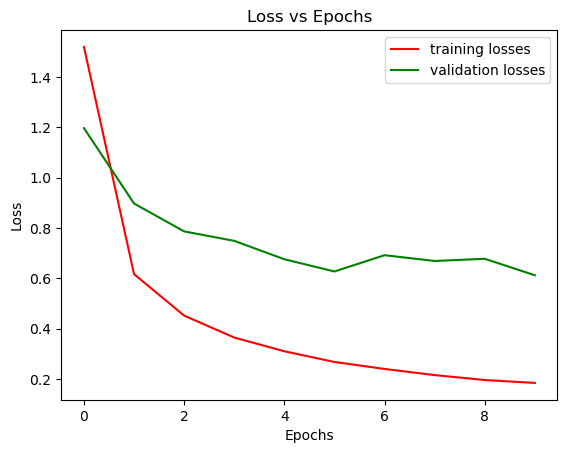

In [121]:
plt.plot(range(10), training_losses, color='red')
plt.plot(range(10), validation_losses, color='green')
plt.legend(['training losses','validation losses'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [126]:
model = CNN(c_in, img_dim, 20)
model.load_state_dict(torch.load('Model/cnn.pth'))
with torch.no_grad():
    accuracy_train = 0
    for inputs, labels in train_loader:
        output1, output2 = model(inputs)
        predicted_1 = torch.argmax(output1, dim = 1,keepdims = True)
        predicted_2 = torch.argmax(output2, dim = 1, keepdims = True)
        predicted_labels = torch.cat((predicted_1, predicted_2), dim = 1)
        accuracy = 0
        for idx in range(len(predicted_labels)):
            if(labels[idx][0] == predicted_labels[idx][0] and labels[idx][1] == predicted_labels[idx][1]):
                accuracy += 1
#             difference = torch.sum(torch.where(labels != predicted_labels, 1.0, 0.0),dim = 1)

        accuracy /= 64
        accuracy_train += accuracy
    print(f"Train Accuracy: {accuracy_train / len(train_loader)}")
    
    accuracy_val = 0
    for inputs, labels in val_loader:
        output1, output2 = model(inputs)
        predicted_1 = torch.argmax(output1, dim = 1,keepdims = True)
        predicted_2 = torch.argmax(output2, dim = 1, keepdims = True)
        predicted_labels = torch.cat((predicted_1, predicted_2), dim = 1)
        accuracy = 0
        for idx in range(len(predicted_labels)):
            if(labels[idx][0] == predicted_labels[idx][0] and labels[idx][1] == predicted_labels[idx][1]):
                accuracy += 1
#             difference = torch.sum(torch.where(labels != predicted_labels, 1.0, 0.0),dim = 1)

        accuracy /= 64
        accuracy_val += accuracy
    print(f"Validation Accuracy: {accuracy_val / len(val_loader)}")

Train Accuracy: 0.9510749724366042
test Accuracy: 0.7880851063829787


In [127]:
with torch.no_grad():
    accuracy_test = 0
    for inputs, labels in test_loader:
        output1, output2 = model(inputs)
        predicted_1 = torch.argmax(output1, dim = 1,keepdims = True)
        predicted_2 = torch.argmax(output2, dim = 1, keepdims = True)
        predicted_labels = torch.cat((predicted_1, predicted_2), dim = 1)
        accuracy = 0
        for idx in range(len(predicted_labels)):
            if(labels[idx][0] == predicted_labels[idx][0] and labels[idx][1] == predicted_labels[idx][1]):
                accuracy += 1
#             difference = torch.sum(torch.where(labels != predicted_labels, 1.0, 0.0),dim = 1)

        accuracy /= 64
        accuracy_test += accuracy
    print(f"test Accuracy: {accuracy_test / len(test_loader)}")

test Accuracy: 0.7580851063829787


# 5.1.3

In [128]:
from PIL import Image

In [129]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transform, 
    download=True
)

In [130]:
def resize_mnist_images(dataset, new_size):
    resized_dataset = []

    for image, label in dataset:
        image = transforms.functional.to_pil_image(image)  # Convert to PIL image
        image = transforms.functional.resize(image, new_size)
        image = transforms.functional.to_tensor(image)  # Convert back to a PyTorch tensor
        resized_dataset.append((image, label))

    return resized_dataset

In [131]:
new_size = (64, 64)
resized_mnist_dataset = resize_mnist_images(mnist_dataset, new_size)

In [133]:
data_loader = DataLoader(resized_mnist_dataset, batch_size = 64, shuffle = True)

In [145]:
input_size = 64*64*1
hidden_layers = 1
hidden_sizes = [300]
num_classes = 20 

In [146]:
model = MLP(input_size, hidden_layers, hidden_sizes, num_classes)
model.load_state_dict(torch.load('Model/mlp.pth'))
with torch.no_grad():
    accuracy_train = 0
    for inputs, labels in data_loader:
        output1, output2 = model(inputs)
        predicted_1 = torch.argmax(output1, dim = 1,keepdims = True)
        predicted_2 = torch.argmax(output2, dim = 1, keepdims = True)
        predicted_labels = torch.cat((predicted_1, predicted_2), dim = 1)
        accuracy = 0
        for idx in range(len(predicted_labels)):
            if(labels[idx] == predicted_labels[idx][0] or labels[idx] == predicted_labels[idx][1]):
                accuracy += 1
#             difference = torch.sum(torch.where(labels != predicted_labels, 1.0, 0.0),dim = 1)

        accuracy /= 64
        accuracy_train += accuracy
    print(f"MNIST Accuracy: {accuracy_train / len(data_loader)}")

MNIST Accuracy: 0.14150786247334754


In [147]:
c_in = 1
img_dim = 64

In [148]:
model = CNN(c_in, img_dim, 20)
model.load_state_dict(torch.load('Model/cnn.pth'))
with torch.no_grad():
    accuracy_train = 0
    for inputs, labels in data_loader:
        output1, output2 = model(inputs)
        predicted_1 = torch.argmax(output1, dim = 1,keepdims = True)
        predicted_2 = torch.argmax(output2, dim = 1, keepdims = True)
        predicted_labels = torch.cat((predicted_1, predicted_2), dim = 1)
        accuracy = 0
        for idx in range(len(predicted_labels)):
            if(labels[idx] == predicted_labels[idx][0] or labels[idx] == predicted_labels[idx][1]):
                accuracy += 1
#             difference = torch.sum(torch.where(labels != predicted_labels, 1.0, 0.0),dim = 1)

        accuracy /= 64
        accuracy_train += accuracy
    print(f"MNIST CNN Accuracy: {accuracy_train / len(data_loader)}")

MNIST CNN Accuracy: 0.10770922174840085


### results
The models dont perform well on the mnist dataset. This may be due to initially the models trained on 64 size images, now with mnist images resized to match the dimensions, thus changing the spatial arrangement of data

# Analysis - DoubleDigit MNIST
## MLP: (epochs 10)
MLP with hyperparameters tuned on validation set shows severe overfitting. The architecture has enough representational power to grow to more than **95% accuracy** on the train set, however gives about **50%** accuracy on the validation and test set, with the Loss VS Epochs plot showing how the model shows overfitting since after 2-3 epochs only.
## CNN: (epochs 10)
CNN with hyperparameters tuned on validation set shows much higher generalisation. The architecture grows to more than **95%** on the train set as well as **~75-80%** on the validation and test set. The loss vs Epochs plot also shows how the model generalises much better than mlp with model not overfitting and adapting well till 5-6 epochs also after which the validation error, unlike the mlp, doesnt overshoot but stays in the same range. 


# 5.2

In [70]:
class CustomDataset(Dataset):
    def __init__(self, train = 1):
        data = np.load("Data/permuted_mnist.npz")
        if(train == 1):
            self.x = torch.tensor(data["train_images"], dtype = torch.float)
            self.y = torch.tensor(data["train_labels"])
        else:
            self.x = torch.tensor(data["test_images"], dtype = torch.float)
            self.y = torch.tensor(data["test_labels"])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = self.x[idx].unsqueeze(0)
        label = self.y[idx]

        return img, label

In [71]:
from torch.utils.data import random_split,DataLoader
training = CustomDataset(1)
training_size = len(training)
train_size = 50000
val_size = 10000
train, val = random_split(training,[train_size, val_size])
test = CustomDataset(0)

In [72]:
train_loader = DataLoader(train, batch_size = 64, shuffle = True)
test_loader = DataLoader(test, batch_size = 64, shuffle = True)
val_loader = DataLoader(val, batch_size = 64, shuffle = True)

# 5.2.1

In [73]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers , hidden_sizes, output_size):
        super(MLP, self).__init__()
        hidden_sizes = [input_size]+hidden_sizes
        self.hidden_layers = hidden_layers
        self.layers = nn.ModuleList([nn.Linear(hidden_sizes[idx-1], hidden_sizes[idx]) for idx in range(1,hidden_layers+1)])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[-1], output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in range(self.hidden_layers):
            x = self.layers[layer](x)
            x = self.relu(x)
    
        x = self.fc2(x)
        return x

In [74]:
input_size = 28*28*1
hidden_layers = 1
hidden_sizes = [300]
num_classes = 10 

model = MLP(input_size, hidden_layers, hidden_sizes, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [75]:
training_losses = []
validation_losses = []
best_validation = float('inf')
for epoch in range(10):
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss_train += loss.item()
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch + 1}, Training Loss: {loss_train / len(train_loader)}")
        training_losses.append(loss_train / len(train_loader))
        
        model.eval()
        loss_eval = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                output = model(inputs)
                loss = criterion(output, labels)
                loss_eval += loss.item()
        print(f"Epoch {epoch + 1}, validation Loss: {loss_eval / len(val_loader)}")
        validation_losses.append(loss_eval / len(val_loader))
        if(validation_losses[-1] < best_validation):
            torch.save(model.state_dict(), 'Model/mlp_2.pth')

if(validation_losses[-1] < best_validation):
    torch.save(model.state_dict(), 'Model/mlp_2.pth')

Epoch 1, Training Loss: 0.6660651430130944
Epoch 1, validation Loss: 0.2363247733302177
Epoch 2, Training Loss: 0.18300676653149736
Epoch 2, validation Loss: 0.185792776494981
Epoch 3, Training Loss: 0.1602166623116502
Epoch 3, validation Loss: 0.1974633058761454
Epoch 4, Training Loss: 0.15762954157740808
Epoch 4, validation Loss: 0.23373239843180746
Epoch 5, Training Loss: 0.15802374889243745
Epoch 5, validation Loss: 0.2043148826979765
Epoch 6, Training Loss: 0.15394980547590303
Epoch 6, validation Loss: 0.27700076026101983
Epoch 7, Training Loss: 0.14279889170182547
Epoch 7, validation Loss: 0.3000130789698499
Epoch 8, Training Loss: 0.14804180481505658
Epoch 8, validation Loss: 0.3160959435597204
Epoch 9, Training Loss: 0.13879913863285084
Epoch 9, validation Loss: 0.2443680735362418
Epoch 10, Training Loss: 0.12165165519351652
Epoch 10, validation Loss: 0.25776066227592115


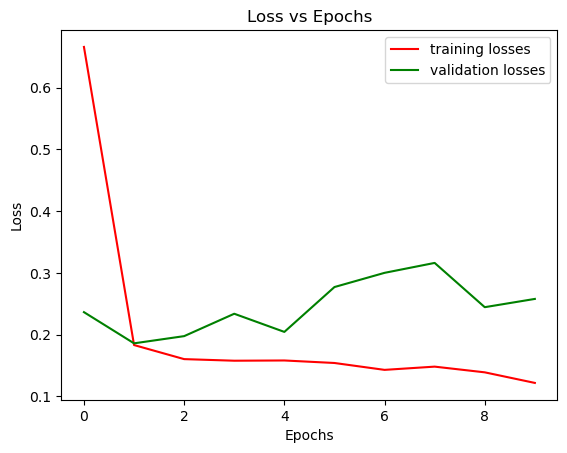

In [76]:
plt.plot(range(10), training_losses, color='red')
plt.plot(range(10), validation_losses, color='green')
plt.legend(['training losses','validation losses'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [77]:
model = MLP(input_size, hidden_layers, hidden_sizes, num_classes)
model.load_state_dict(torch.load('Model/mlp_2.pth'))
with torch.no_grad():
    accuracy_train = 0
    for inputs, labels in train_loader:
        output = model(inputs)
        predicted = torch.argmax(output, dim = 1)
        correct = torch.sum(torch.where(predicted == labels,1.0,0.0))
        accuracy_train += correct / len(labels)
    print(f"Train Accuracy: {accuracy_train / len(train_loader)}")
    
    accuracy_val = 0
    for inputs, labels in val_loader:
        output = model(inputs)
        predicted = torch.argmax(output, dim = 1)
        correct = torch.sum(torch.where(predicted == labels,1.0,0.0))
        accuracy_val += correct / len(labels)
    print(f"Validation Accuracy: {accuracy_val / len(val_loader)}")
    
    accuracy_test = 0
    for inputs, labels in test_loader:
        output = model(inputs)
        predicted = torch.argmax(output, dim = 1)
        correct = torch.sum(torch.where(predicted == labels,1.0,0.0))
        accuracy_test += correct / len(labels)
    print(f"Testing Accuracy: {accuracy_test / len(test_loader)}")

Train Accuracy: 0.977441668510437
Validation Accuracy: 0.9599920511245728
Testing Accuracy: 0.9621815085411072


# 5.2.2

In [78]:
class CNN(nn.Module):
    def __init__(self,c_in, img_dim, num_classes=20):
        super(CNN, self).__init__()
#         image shape (N,c_in,dim,dim)
        self.conv1 = nn.Conv2d(c_in, 32, kernel_size=3) # (N,c_out, dim-2,dim-2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # (N,c_out, dim-2 // 2,dim-2 // 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # (N,c_out2, dim-2 // 2 - 2,dim-2 // 2 - 2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # (N,c_out2, (((dim-2) // 2) - 2) // 2,(((dim-2) // 2) - 2) // 2)
        self.dropout = nn.Dropout2d(0.25)
        last_dim = (((img_dim-2) // 2) - 2) // 2
        self.fc1 = nn.Linear(64 *last_dim*last_dim, num_classes)
        self.smax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
#         x = self.smax(x)
        return x

In [79]:
c_in = 1
img_dim = 28

model = CNN(c_in, img_dim, 10)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [80]:
training_losses = []
validation_losses = []
best_validation = float('inf')
for epoch in range(10):
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss_train += loss.item()
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch + 1}, Training Loss: {loss_train / len(train_loader)}")
        training_losses.append(loss_train / len(train_loader))
        
        model.eval()
        loss_eval = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                output = model(inputs)
                loss = criterion(output, labels)
                loss_eval += loss.item()
        print(f"Epoch {epoch + 1}, validation Loss: {loss_eval / len(val_loader)}")
        validation_losses.append(loss_eval / len(val_loader))
        if(validation_losses[-1] < best_validation):
            torch.save(model.state_dict(), 'Model/cnn_2.pth')

if(validation_losses[-1] < best_validation):
    torch.save(model.state_dict(), 'Model/cnn_2.pth')

Epoch 1, Training Loss: 0.9461263394092813
Epoch 1, validation Loss: 0.3624672523824273
Epoch 2, Training Loss: 0.4338478617408239
Epoch 2, validation Loss: 0.31353067450082983
Epoch 3, Training Loss: 0.3621122765895503
Epoch 3, validation Loss: 0.2575403708418843
Epoch 4, Training Loss: 0.320970364991585
Epoch 4, validation Loss: 0.23461191123648054
Epoch 5, Training Loss: 0.2706748919937845
Epoch 5, validation Loss: 0.2457568900908824
Epoch 6, Training Loss: 0.24878115316047844
Epoch 6, validation Loss: 0.20196025782994403
Epoch 7, Training Loss: 0.22587083676434538
Epoch 7, validation Loss: 0.19545241063282748
Epoch 8, Training Loss: 0.20215216687287363
Epoch 8, validation Loss: 0.18309394060189177
Epoch 9, Training Loss: 0.18925888594144674
Epoch 9, validation Loss: 0.17316728685596947
Epoch 10, Training Loss: 0.1800708780160455
Epoch 10, validation Loss: 0.18335380832290954


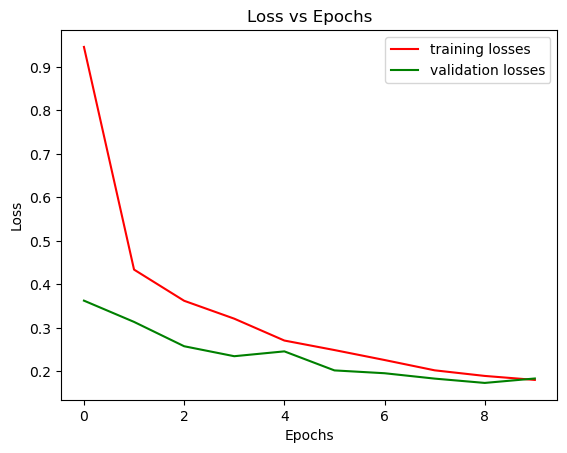

In [81]:
plt.plot(range(10), training_losses, color='red')
plt.plot(range(10), validation_losses, color='green')
plt.legend(['training losses','validation losses'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [82]:
model = CNN(c_in, img_dim, 10)
model.load_state_dict(torch.load('Model/cnn_2.pth'))
with torch.no_grad():
    accuracy_train = 0
    for inputs, labels in train_loader:
        output = model(inputs)
        predicted = torch.argmax(output, dim = 1)
        correct = torch.sum(torch.where(predicted == labels,1.0,0.0))
        accuracy_train += correct / len(labels)
    print(f"Train Accuracy: {accuracy_train / len(train_loader)}")
    
    accuracy_val = 0
    for inputs, labels in val_loader:
        output = model(inputs)
        predicted = torch.argmax(output, dim = 1)
        correct = torch.sum(torch.where(predicted == labels,1.0,0.0))
        accuracy_val += correct / len(labels)
    print(f"Validation Accuracy: {accuracy_val / len(val_loader)}")
    
    accuracy_test = 0
    for inputs, labels in test_loader:
        output = model(inputs)
        predicted = torch.argmax(output, dim = 1)
        correct = torch.sum(torch.where(predicted == labels,1.0,0.0))
        accuracy_test += correct / len(labels)
    print(f"Testing Accuracy: {accuracy_test / len(test_loader)}")

Train Accuracy: 0.948309600353241
Validation Accuracy: 0.931329607963562
Testing Accuracy: 0.9322253465652466


# Analysis - Permuted MNIST
## MLP: (epochs 10)
MLP with hyperparameters tuned on validation set performs much better compared to Doubledigit MNIST. The mlp tuned is able to extract features of the data rather than memorizing specific pixel patterns such as density of pixel intensity, No.of pixels with higher intensity(Eg for '1' the intensity is less than that in case of '8'). The model performs with accuracy of **97%**. Although it shows little overfitting, MLP performs with accuracy of **95%** on the validation and test set
## CNN: (epochs 10)
CNN with hyperparameters tuned on validation set performs much better compared to Doubledigit MNIST. The CNN tuned is able to extract features of the data rather than memorizing specific pixel patterns such as density of pixel intensity, No.of pixels with higher intensity(Eg for '1' the intensity is less than that in case of '8'). The model performs with accuracy of **95%**. It shows much less overfitting as is evident in the lLoss VS Epochs graph and performs with accuracy of **95%** on the validation and test set.

The mlp performs better than cnn because since there is no local neighbourhood patterns in the image, the use of cnn is not needed. The MLP on the other hand is not trained to learn of these features hence it generalises well.

# 5.3
- Analysis and graphs done for each dataset separately